<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch5-MonteCarloMethods/RaceTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
from tqdm import tqdm
# np.random.seed(0)

### Initialize Tracks

In [2]:
def get_circuits():
  nRows_1 = 32
  nCols_1 = 17
  map_1 = np.zeros((nRows_1,nCols_1))
  map_1[-1,3:9] = 1
  map_1[0:6,-1] = 2
  map_1[-3:,:3] = 3
  map_1[-10:-3:,:2] = 3
  map_1[-18:-10:,:1] = 3
  map_1[0,:3] = 3
  map_1[1:3,:2] = 3
  map_1[3,:1] = 3
  map_1[7:,9:] = 3
  map_1[6,10:] = 3

  nRows_2 = 30
  nCols_2 = 32
  map_2 = np.zeros((nRows_2,nCols_2))
  map_2[-1,:23] = 1
  map_2[0:9,-1] = 2
  map_2[-17:,23:] = 3
  map_2[-18:,24:] = 3
  map_2[-19:,26:] = 3
  map_2[-20:,27:] = 3
  map_2[-21:,30:] = 3
  map_2[0,:16] = 3
  map_2[[1,8],:13] = 3
  map_2[[2,7],:12] = 3
  map_2[3:7,:11] = 3
  map_2[9:14,:14] = 3
  c = 1
  for i in range(14,nRows_2-2):
    map_2[i,:14-c] = 3
    c += 1
  return map_1,map_2

def plot_circuit(fig,map,num):
  nRows,nCols = map.shape
  # create discrete colormap
  #cmap = colors.ListedColormap(['red', 'blue'])
  cmap = colors.ListedColormap(['white','red','green','black'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  ax = fig.add_subplot(1,2,num)
  ax.imshow(map, cmap=cmap)#, norm=norm)

  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, nRows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, nRows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

### Visualize Race Tracks

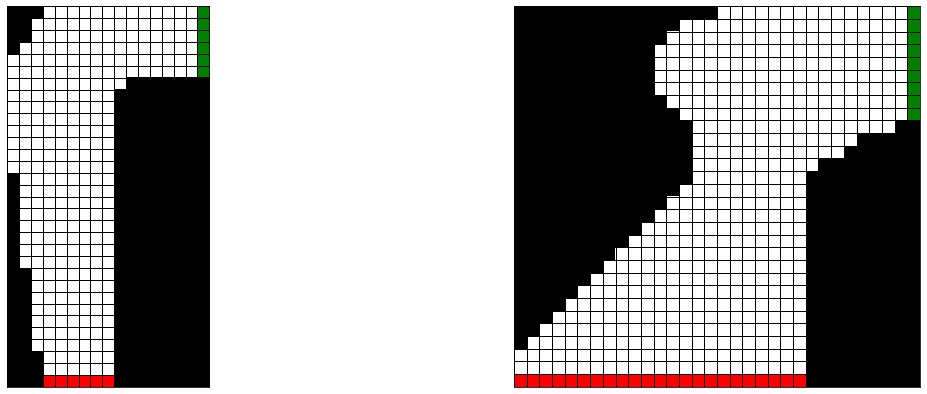

In [3]:
map_1,map_2 = get_circuits()
fig = plt.figure(figsize=(20,7))#20,7)
plot_circuit(fig,map_1,1)
plot_circuit(fig,map_2,2)

In [4]:
max_velocity = 5
actions = np.array([[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]])
gamma = 1.0

def init_state(map):
  find_start_line = np.where(map == 1)
  start_line = np.array(list(zip(find_start_line[0],find_start_line[1])))
  choice = np.random.choice(range(start_line.shape[0]))
  init = [start_line[choice,0],start_line[choice,1],0,0]
  ## print('Start Line Coordinates:',start_line)
  ## print(choice,init)
  return init

def check_termination(map,curr_state):
  finish_line = np.where(map == 2)
  return curr_state[1] > finish_line[1][0] and curr_state[0] >= np.min(finish_line[0]) and curr_state[0] <= np.max(finish_line[0])

def check_OutOfBounds(map,curr_state):
  if min(curr_state[0],curr_state[1]) < 0:
    return True
  elif check_termination(map,curr_state):
    return False
  elif curr_state[1] >= map.shape[1] or curr_state[0] >= map.shape[0]:
    return True
  return map[curr_state[0],curr_state[1]] == 3

def is_init(map,state):
  return map[state[0],state[1]] == 1

def behavior_policy(map,state):
  act_idx = np.arange(actions.shape[0])
  prob = 1
  if is_init(map,state):
    idx = np.where(actions[:,0] < 0)[0]
    prob = 1/float(len(idx))
    act_idx = idx
  elif state[2]==0 and state[3] == 0:
    idx1 = np.where(actions[:,0] == 0)[0]
    idx2 = np.where(actions[idx1,1] == 0)[0]
    idx3 = idx1[idx2]
    idx = np.arange(actions.shape[0])
    act_idx = np.delete(idx,idx3)
    prob = 1/float(len(act_idx))
  if state[2] == 5:
    idx = np.where(actions[:,0] < 1)[0]
    prob = 1/float(len(idx))
    act_idx = idx
  elif state[2] == -5:
    idx = np.where(actions[:,0] > -1)[0]
    prob = 1/float(len(idx))
    act_idx = idx
  if state[3] == 5:
    # print(np.where(actions[act_idx,1] < 1)[0])
    # print(act_idx)
    idx = np.where(actions[act_idx,1] < 1)[0]
    prob = 1/float(len(idx))
    act_idx = act_idx[idx]
  elif state[3] == -5:
    idx = np.where(actions[act_idx,1] > -1)[0]
    prob = 1/float(len(idx))
    act_idx = act_idx[idx]
  if len(act_idx) == actions.shape[0]:
    prob = 1/float(actions.shape[0])
    act_idx = [np.random.choice(range(actions.shape[0]))]
  return actions[np.random.choice(act_idx),:],np.round(prob,3)

def get_action_idx(action):
  return np.where(np.sum(np.abs(actions-action),1) == 0)[0][0]

def move(state,input):
  new_vel = [state[2]+input[0],state[3]+input[1]]
  new_state = [state[0]+new_vel[0],state[1]+new_vel[1]] + new_vel
  return new_state

def play(map,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  action_prob = []
  while not check_termination(map,curr_state):
    reward -= 1
    act,prob = behavior_policy(map,curr_state)
    next_state = move(curr_state,act)
    # print("################")
    # print(curr_state)
    # print(new_vel)
    # print(next_state)
    if check_OutOfBounds(map,next_state):
      return -1,traj,action_prob
      # curr_state = init_state(map)
      # traj = [curr_state]
      # action_prob = []
      # continue
    else:
      curr_state = next_state
    action_prob += [list(act) + [prob]]
    traj += [curr_state]
  return 1,traj,action_prob

def target_policy(Q,state):
  best_action = [np.argmax(Q[state[0],state[1],max_velocity+state[2],max_velocity+state[3],:])]
  if len(best_action) < 1:
    print('No Best Action')
    print('State:',state)
    print('Action:',Q[state[0],state[1],:])
  return np.random.choice(best_action),np.round(1/float(len(best_action)),3)

def play_target(map,Q,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  action_prob = []
  while not check_termination(map,curr_state):
    # print(curr_state)
    reward -= 1
    a,prob = target_policy(Q,curr_state)
    act = actions[a]
    new_vel = [curr_state[2]+act[0],curr_state[3]+act[1]]
    next_state = [curr_state[0]+new_vel[0],curr_state[1]+new_vel[1],new_vel[0],new_vel[1]] 
    if check_OutOfBounds(map,next_state):
      # curr_state = init_state(map)
      break
    else:
      curr_state = next_state
    action_prob += [list(act) + [prob]]
    traj += [curr_state]
  return reward,traj,action_prob

def MonteCarlo_OffPolicyControl(map,num_episodes):
  nRows,nCols = map.shape
  action_values  = np.zeros((nRows,nCols,2*max_velocity+1,2*max_velocity+1,len(actions)))
  action_weights = np.zeros((nRows,nCols,2*max_velocity+1,2*max_velocity+1,len(actions)))

  for episode in tqdm(range(num_episodes)):
    init = init_state(map)
    reward,traj,action_prob = play(map,init)
    G = 0
    W = 1
    for i in range(len(traj)-2,-1,-1):
      t = traj[i]
      act_prob = action_prob[i]
      G = reward#gamma*G + reward
      act_idx = get_action_idx(np.array(act_prob[:2]))
      action_weights[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx] += W
      action_values[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx] += W/action_weights[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx]*(G-action_values[t[0],t[1],max_velocity+t[2],max_velocity+t[3],act_idx])
      pi_t,_ = target_policy(action_values,t)
      if pi_t != act_idx:
        break
      W = W/act_prob[-1]
  return action_values

Reward = : -1
4 3
[28, 2, -2, -1]
[-1, 1, 0.111]


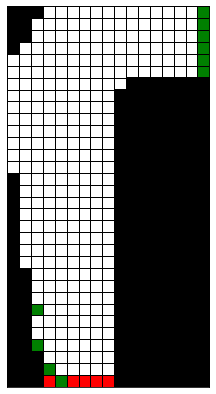

In [5]:
map = np.copy(map_1)
init = init_state(map)
reward,traj,action_prob = play(map,init)
print('Reward = :',reward)
final_map = np.copy(map)
for i,t in enumerate(traj):
  final_map[min(t[0],map.shape[0]-1),min(t[1],map.shape[1]-1)] = 1.5
  # if i < len(traj)-1:
  #   print(t,action_prob[i])
  # else:
  #   print(t)
print(len(traj),len(action_prob))
print(traj[-2])
print(action_prob[-1])
fig = plt.figure(figsize=(20,7))
plot_circuit(fig,final_map,1)

In [6]:
num_episodes = 100000
map = np.copy(map_1)
Q = MonteCarlo_OffPolicyControl(map,num_episodes)

100%|██████████| 100000/100000 [00:45<00:00, 2184.19it/s]


Reward = : -15
Reward = : -15


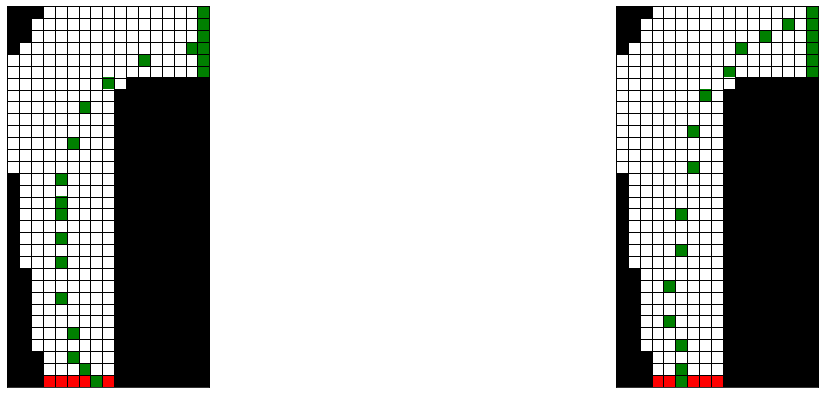

In [13]:
final_map = []
for k in range(2):
  test_state = init_state(map)
  reward,traj,action_prob = play_target(map,Q,test_state)
  print('Reward = :',reward)
  final_map.append(np.copy(map))
  for i,t in enumerate(traj):
    final_map[-1][min(t[0],map.shape[0]-1),min(t[1],map.shape[1]-1)] = 1.5
fig = plt.figure(figsize=(20,7))
plot_circuit(fig,final_map[0],1)
plot_circuit(fig,final_map[1],2)

In [8]:
test_state = init_state(map)
idx,prob = target_policy(Q,test_state)
print(test_state)
print(actions[idx],prob)
while not check_OutOfBounds(map,test_state):
  act = actions[idx]
  next_state = move(test_state,act)
  idx,prob = target_policy(Q,next_state)
  print("############")
  print(next_state)
  print(actions[idx],prob)
  test_state = next_state

[31, 6, 0, 0]
[-1 -1] 1.0
############
[30, 5, -1, -1]
[-1  0] 1.0
############
[28, 4, -2, -1]
[0 1] 1.0
############
[26, 4, -2, 0]
[0 1] 1.0
############
[24, 5, -2, 1]
[-1  1] 1.0
############
[21, 7, -3, 2]
[-1 -1] 1.0
############
[17, 8, -4, 1]
[ 1 -1] 1.0
############
[14, 8, -3, 0]
[-1  0] 1.0
############
[10, 8, -4, 0]
[1 0] 1.0
############
[7, 8, -3, 0]
[1 1] 1.0
############
[5, 9, -2, 1]
[ 1 -1] 1.0
############
[4, 9, -1, 0]
[0 1] 1.0
############
[3, 10, -1, 1]
[1 1] 1.0
############
[3, 12, 0, 2]
[0 0] 1.0
############
[3, 14, 0, 2]
[-1  0] 1.0
############
[2, 16, -1, 2]
[-1  0] 1.0


IndexError: ignored

In [ ]:
print(behavior_policy(map,[0,0,-5,-5]))
# idx = np.where(actions[:,0] > -1)[0]
# prob = 1/float(len(idx))
# act_idx = [np.random.choice(idx)]
# print(act_idx)


In [ ]:
idx1 = np.where(actions[:,0] == 0)[0]
idx2 = np.where(actions[idx1,1] == 0)[0]
act_idx = idx1[idx2]
idx = np.arange(actions.shape[0])
act_idx = np.delete(idx,act_idx)
print(actions[act_idx])